In [1]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType
from pyspark.shell import spark

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.0
      /_/

Using Python version 3.6.3 (default, Oct  6 2017 12:04:38)
SparkSession available as 'spark'.


In [2]:
df = spark.read.format('csv').option('sep', '\t').schema(schema).load('inputs/mini-sample.tdv.gz')

In [3]:
col_names = []
for i in range(2,len(df.columns)):
    col_names.append(df.columns[i])

In [4]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols=col_names,
                                  outputCol="features")
trans_features = vectorAssembler.transform(df)
coeff = Correlation.corr(trans_features,'features',method='pearson').collect()[0][0]

In [5]:
mtrx = coeff.toArray()

In [6]:
list_corr_pairs_coeffs = []
feature_pairs = []

for i in range(0,56):
    for j in range(0,56):
        
        if (i != j) and not(((col_names[i]+"_"+col_names[j]) in feature_pairs) or
                         ((col_names[j]+"_"+col_names[i]) in feature_pairs)):
            feature_pairs.append(col_names[i] +"_"+col_names[j])
            corr_pair_coeff = []
            corr_pair_coeff.append(col_names[i]+" , "+col_names[j])
            corr_pair_coeff.append(col_names[i])
            corr_pair_coeff.append(col_names[j])
            corr_pair_coeff.append(float(mtrx[i][j]))
            list_corr_pairs_coeffs.append(tuple(corr_pair_coeff))

In [7]:
df_corr_coeff_col_names = []
df_corr_coeff_col_names.append(StructField("Feature_Pair", StringType(), True))
df_corr_coeff_col_names.append(StructField("Feature1", StringType(), True))
df_corr_coeff_col_names.append(StructField("Feature2", StringType(), True))
df_corr_coeff_col_names.append(StructField("Pearson_Coeff", FloatType(), True))
df_corr_coeff = spark.createDataFrame(list_corr_pairs_coeffs,StructType(df_corr_coeff_col_names))

In [8]:
#relative_humidity_zerodegc_isotherm
df_corr_coeff.where((df_corr_coeff.Feature1 == 'relative_humidity_zerodegc_isotherm') | 
                    (df_corr_coeff.Feature2 == 'relative_humidity_zerodegc_isotherm')
                   ).sort(df_corr_coeff.Pearson_Coeff.desc()).show(n=10)

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|relative_humidity...|relative_humidity...| pressure_tropopause|   0.50406015|
|relative_humidity...|relative_humidity...|temperature_tropo...|   0.45509925|
|relative_humidity...|relative_humidity...|maximumcomposite_...|   0.44944143|
|relative_humidity...|relative_humidity...|  snow_cover_surface|   0.35365328|
|relative_humidity...|relative_humidity...|      albedo_surface|   0.31858346|
|relative_humidity...|relative_humidity...|plant_canopy_surf...|    0.2979641|
|relative_humidity...|relative_humidity...|categorical_rain_...|    0.2908854|
|number_of_soil_la...|number_of_soil_la...|relative_humidity...|   0.25693217|
|relative_humidity...|relative_humidity...|soil_porosity_sur...|   0.24705465|
|relative_humidity...|relative_humidity...|land_cove

In [9]:
#relative_humidity_zerodegc_isotherm
df_corr_coeff.where((df_corr_coeff.Feature1 == 'relative_humidity_zerodegc_isotherm') | 
                    (df_corr_coeff.Feature2 == 'relative_humidity_zerodegc_isotherm')
                   ).sort(df_corr_coeff.Pearson_Coeff.asc()).show(n=10)

+--------------------+--------------------+--------------------+-------------+
|        Feature_Pair|            Feature1|            Feature2|Pearson_Coeff|
+--------------------+--------------------+--------------------+-------------+
|relative_humidity...|relative_humidity...|geopotential_heig...|  -0.58565533|
|relative_humidity...|relative_humidity...| temperature_surface|  -0.41653106|
|relative_humidity...|relative_humidity...|upward_long_wave_...|   -0.3741724|
|visibility_surfac...|  visibility_surface|relative_humidity...|   -0.3378231|
|geopotential_heig...|geopotential_heig...|relative_humidity...|  -0.29624322|
|relative_humidity...|relative_humidity...|downward_long_wav...|  -0.22544569|
|relative_humidity...|relative_humidity...|    pressure_surface|  -0.20205103|
|pressure_reduced_...|pressure_reduced_...|relative_humidity...|  -0.18637426|
|relative_humidity...|relative_humidity...|mean_sea_level_pr...|  -0.18091883|
|relative_humidity...|relative_humidity...|downward_

In [12]:
feature2 = df_corr_coeff.where((df_corr_coeff.Feature1 == 'relative_humidity_zerodegc_isotherm') | 
                    (df_corr_coeff.Feature2 == 'relative_humidity_zerodegc_isotherm')
                   ).sort(df_corr_coeff.Pearson_Coeff.desc()).select(df_corr_coeff.Feature2)
feature2.take(10)

[Row(Feature2='pressure_tropopause'),
 Row(Feature2='temperature_tropopause'),
 Row(Feature2='maximumcomposite_radar_reflectivity_entire_atmosphere'),
 Row(Feature2='snow_cover_surface'),
 Row(Feature2='albedo_surface'),
 Row(Feature2='plant_canopy_surface_water_surface'),
 Row(Feature2='categorical_rain_yes1_no0_surface'),
 Row(Feature2='relative_humidity_zerodegc_isotherm'),
 Row(Feature2='land_cover_land1_sea0_surface'),
 Row(Feature2='soil_porosity_surface')]

In [13]:
feature1 = df_corr_coeff.where((df_corr_coeff.Feature1 == 'relative_humidity_zerodegc_isotherm') | 
                    (df_corr_coeff.Feature2 == 'relative_humidity_zerodegc_isotherm')
                   ).sort(df_corr_coeff.Pearson_Coeff.desc()).select(df_corr_coeff.Feature1)
feature1.take(10)

[Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='number_of_soil_layers_in_root_zone_surface'),
 Row(Feature1='relative_humidity_zerodegc_isotherm'),
 Row(Feature1='relative_humidity_zerodegc_isotherm')]

In [14]:
#pressure_tropopause
#temperature_tropopause
#maximumcomposite_radar_reflectivity_entire_atmosphere
#snow_cover_surface
#albedo_surface
#plant_canopy_surface_water_surface
#categorical_rain_yes1_no0_surface
#land_cover_land1_sea0_surface
#soil_porosity_surface

In [16]:
def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["pressure_tropopause", 
         "temperature_tropopause", 
         "maximumcomposite_radar_reflectivity_entire_atmosphere", 
         "snow_cover_surface",
         "albedo_surface",
         "plant_canopy_surface_water_surface",
         "categorical_rain_yes1_no0_surface",
         "land_cover_land1_sea0_surface",
         "soil_porosity_surface"],
    "relative_humidity_zerodegc_isotherm")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(9,[0,1,2,4],[128...| 62.0|
|[22776.14453125,2...| 88.0|
|[30109.478515625,...| 74.0|
|[23656.310546875,...| 77.0|
|(9,[0,1,2,4],[103...|  3.0|
|[35929.86328125,2...| 64.0|
|(9,[0,1,2,4],[955...| 20.0|
|[19234.021484375,...| 91.0|
|(9,[0,1,2,4],[204...| 94.0|
|(9,[0,1,2,4],[115...| 82.0|
|[11434.021484375,...| 98.0|
|(9,[0,1,2,4],[264...| 87.0|
|[22614.12109375,2...| 97.0|
|(9,[0,1,2,4],[114...| 75.0|
|[32024.40234375,2...| 76.0|
|[21624.40234375,2...| 38.0|
|(9,[0,1,2,4],[166...| 65.0|
|[34219.89453125,2...| 57.0|
|[9206.98046875,19...|  8.0|
|(9,[0,1,2,4],[247...| 96.0|
+--------------------+-----+
only showing top 20 rows



In [22]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=10, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

In [23]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 23.0501


In [17]:
samp_predns = predictions.sample(False, .1)
samp_predns

DataFrame[features: vector, label: float, prediction: double]

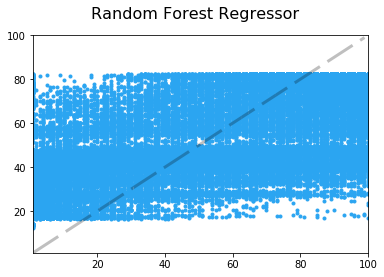

In [18]:
import matplotlib.pyplot as plt

p_df = samp_predns.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

In [21]:
trainingData.select(*trainingData.columns).show(n=5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6653.146484375,2...| 80.0|
|[7142.98095703125...| 53.0|
|[7142.98095703125...| 60.0|
|[7142.98095703125...| 72.0|
|[7142.98095703125...| 67.0|
+--------------------+-----+
only showing top 5 rows



In [29]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol="features",labelCol="label",predictionCol="prediction",maxDepth=5)
model_dt = dt.fit(trainingData)

In [30]:
model.depth

5

In [31]:
model.numNodes

63

In [32]:
predictions_dt = model_dt.transform(testData)

evaluator_dt = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator_dt.evaluate(predictions_dt)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 24.6164


In [ ]:
#pressure_tropopause
#temperature_tropopause
#geopotential_height_zerodegc_isotherm
#temperature_surface

#relative_humidity_zerodegc_isotherm - want 